# File and libraries

In [122]:
import pandas as pd
import numpy as np

# DSLabs functions

In [123]:
%run "scripts/dslabs_functions.py"

# Data functions

In [124]:
%run "scripts/data_functions.py"

data_functions loaded


# Load

In [125]:
train=pd.read_csv(f"dataset/series_scaled_agg_w_train.csv", index_col='date', parse_dates=True,  infer_datetime_format=True)
test=pd.read_csv(f"dataset/series_scaled_agg_w_test.csv", index_col='date', parse_dates=True,  infer_datetime_format=True)

target='sales'
file_tag = "Ecuadorian Store Sales"

trnX = train.drop(columns=[target])
trnY = train[target]
tstX = test.drop(columns=[target])
tstY = test[target]

In [126]:
print("Train Frequency:", pd.infer_freq(train.index))
print("Test Frequency:", pd.infer_freq(test.index))

Train Frequency: W-MON
Test Frequency: W-MON


In [127]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 193 entries, 2012-12-31 to 2016-09-05
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   193 non-null    float64
dtypes: float64(1)
memory usage: 3.0 KB


In [128]:
train.head()

,sales
date,
2012-12-31,-0.107524
2013-01-07,-0.102713
2013-01-14,-0.157644
2013-01-21,-0.204250
2013-01-28,-0.087915


In [129]:
trnY.head()

date
2012-12-31   -0.107524
2013-01-07   -0.102713
2013-01-14   -0.157644
2013-01-21   -0.204250
2013-01-28   -0.087915
Name: sales, dtype: float64

In [130]:
trnX.head()

""
date
2012-12-31
2013-01-07
2013-01-14
2013-01-21
2013-01-28


In [131]:
print(f"Train NaNs: {train.isna().sum()} | Test NaNs: {test.isna().sum()}")

Train NaNs: sales    0
dtype: int64 | Test NaNs: sales    0
dtype: int64


# ARIMA Univariate

## ARIMA Study

NaN Check - Train: 0 | Test: 0
Before Setting Freq - Train Shape: (193,), Test Shape: (49,)
After Setting Freq - Train Shape: (193,), Test Shape: (49,)
Inferred Train Frequency: W-MON | Inferred Test Frequency: W-MON
Trying ARIMA(1, 0, 1) on 193 training points
ARIMA(1, 0, 1) -> R2: -1.9896
Trying ARIMA(2, 0, 1) on 193 training points
ARIMA(2, 0, 1) -> R2: -1.8689
Trying ARIMA(3, 0, 1) on 193 training points


ARIMA(3, 0, 1) -> R2: -1.6189
Trying ARIMA(5, 0, 1) on 193 training points
ARIMA(5, 0, 1) -> R2: -1.7822
Trying ARIMA(7, 0, 1) on 193 training points
ARIMA(7, 0, 1) -> R2: -1.9134
Trying ARIMA(10, 0, 1) on 193 training points
ARIMA(10, 0, 1) -> R2: -2.1311
Trying ARIMA(1, 0, 3) on 193 training points
ARIMA(1, 0, 3) -> R2: -1.6922
Trying ARIMA(2, 0, 3) on 193 training points
ARIMA(2, 0, 3) -> R2: -1.7991
Trying ARIMA(3, 0, 3) on 193 training points
ARIMA(3, 0, 3) -> R2: -2.0085
Trying ARIMA(5, 0, 3) on 193 training points
ARIMA(5, 0, 3) -> R2: -1.6448
Trying ARIMA(7, 0, 3) on 193 training points
ARIMA(7, 0, 3) -> R2: -1.9204
Trying ARIMA(10, 0, 3) on 193 training points
ARIMA(10, 0, 3) -> R2: -1.9945
Trying ARIMA(1, 0, 5) on 193 training points
ARIMA(1, 0, 5) -> R2: -1.6000
Trying ARIMA(2, 0, 5) on 193 training points
ARIMA(2, 0, 5) -> R2: -1.6473
Trying ARIMA(3, 0, 5) on 193 training points
ARIMA(3, 0, 5) -> R2: -1.7237
Trying ARIMA(5, 0, 5) on 193 training points
ARIMA(5, 0, 5) -> R2:

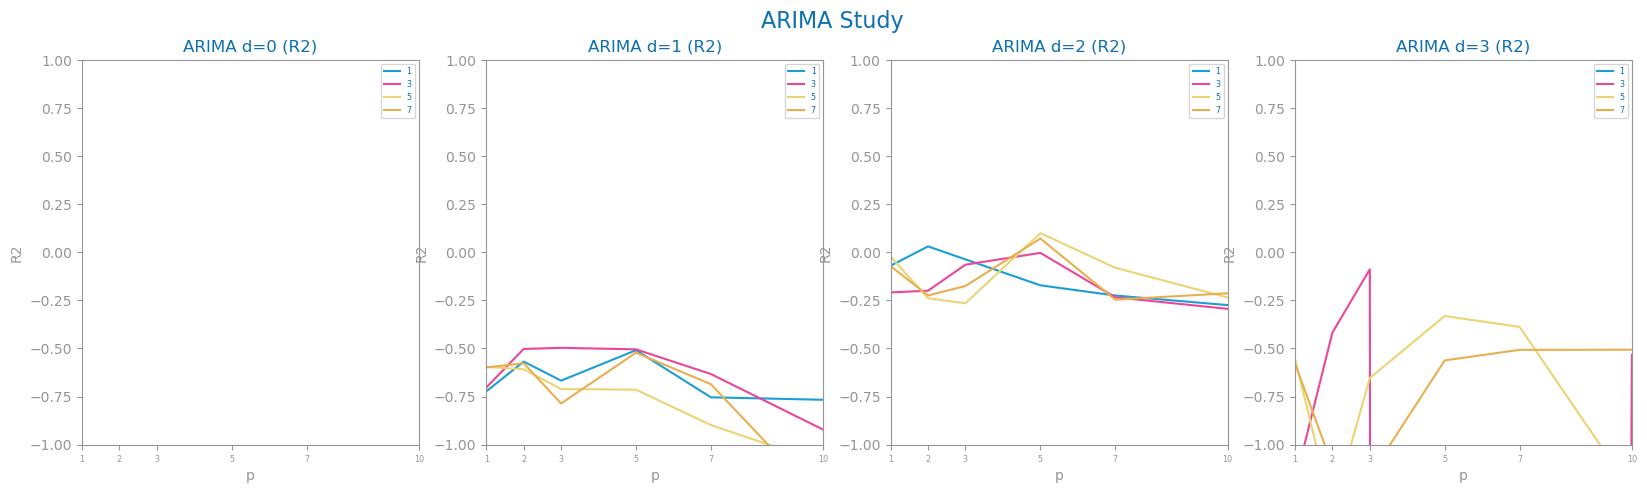

In [132]:
from matplotlib.pyplot import figure, savefig, subplots
import warnings
from statsmodels.tsa.arima.model import ARIMA
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart
from pandas import Series
import pandas as pd
from numpy import isfinite


def arima_uni_study(train: Series, test: Series, measure: str = "R2", freq: str = None):
    # Ensure data does not contain NaN or infinite values
    train = train[isfinite(train)]
    test = test[isfinite(test)]

    print(f"NaN Check - Train: {train.isna().sum()} | Test: {test.isna().sum()}")  # Debugging step
    print(f"Before Setting Freq - Train Shape: {train.shape}, Test Shape: {test.shape}")

    # Set frequency if provided
    if freq:
        train = train.asfreq(freq, method='ffill')  # Fill missing values if any
        test = test.asfreq(freq, method='ffill')

    print(f"After Setting Freq - Train Shape: {train.shape}, Test Shape: {test.shape}")
    print(f"Inferred Train Frequency: {pd.infer_freq(train.index)} | Inferred Test Frequency: {pd.infer_freq(test.index)}")

    d_values = (0, 1, 2, 3)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    flag = measure in {"R2", "MAPE"}
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * 5, 5))
    fig.suptitle(f"ARIMA Study", fontsize=16)

    for i, d in enumerate(d_values):
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                try:
                    print(f"Trying ARIMA({p}, {d}, {q}) on {len(train)} training points")  # Debugging step
                    arima = ARIMA(train, order=(p, d, q))
                    model = arima.fit(method_kwargs={"maxiter": 500})  # Increase iterations
                    prd_tst = model.forecast(steps=len(test))
                    
                    # Ensure forecast length matches test length
                    if len(prd_tst) != len(test):
                        print(f"Warning: Forecast length ({len(prd_tst)}) != Test length ({len(test)})")
                        prd_tst = prd_tst[:len(test)]

                    eval_score: float = FORECAST_MEASURES[measure](test, prd_tst)
                    print(f"ARIMA({p}, {d}, {q}) -> {measure}: {eval_score:.4f}")

                    if eval_score > best_performance and abs(eval_score - best_performance) > DELTA_IMPROVE:
                        best_performance = eval_score
                        best_params["params"] = (p, d, q)
                        best_model = model

                    yvalues.append(eval_score)
                except Exception as e:
                    print(f"Failed ARIMA({p}, {d}, {q}): {e}")
                    yvalues.append(None)

            values[q] = yvalues

        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )

    if best_params["params"]:
        print(
            f"ARIMA best results with (p,d,q)=({best_params['params'][0]}, {best_params['params'][1]}, {best_params['params'][2]})"
            f" ==> {measure}={best_performance:.2f}"
        )
    else:
        print("No valid ARIMA model found.")

    return best_model, best_params


# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

# Run ARIMA study
measure = "R2"
best_model, best_params = arima_uni_study(trnY, tstY, measure=measure) #, freq="W")
savefig(f"{file_tag}_arima_univariate_{measure}_study.png")


## ARIMA Model Creation

In [133]:
from statsmodels.tsa.arima.model import ARIMA

best_params["params"]

predictor = ARIMA(endog=trnY, order=(best_params["params"][0], best_params["params"][1], best_params["params"][2]))
model = predictor.fit()
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  193
Model:                 ARIMA(5, 2, 5)   Log Likelihood                 237.543
Date:                Sun, 23 Mar 2025   AIC                           -453.086
Time:                        22:14:13   BIC                           -417.311
Sample:                    12-31-2012   HQIC                          -438.595
                         - 09-05-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7236      0.286     -6.020      0.000      -2.285      -1.162
ar.L2         -2.1556      0.376     -5.739      0.000      -2.892      -1.419
ar.L3         -1.9687      0.314     -6.273      0.0

## ARIMA Model Plot Diagnostics

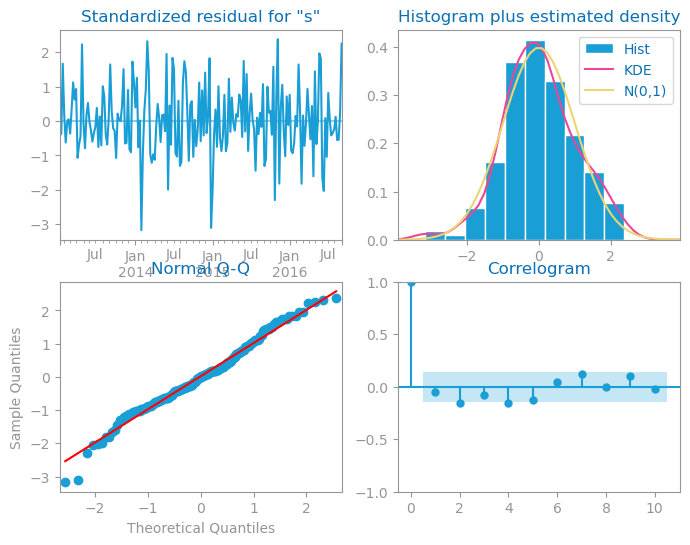

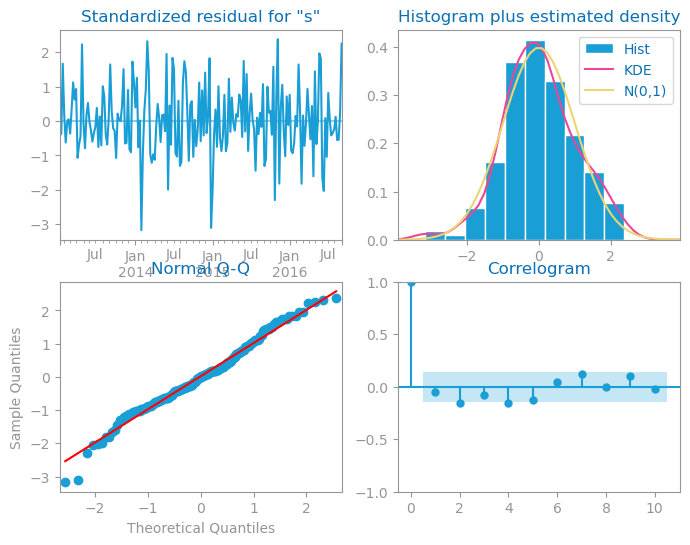

In [134]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))


## ARIMA Evaluate

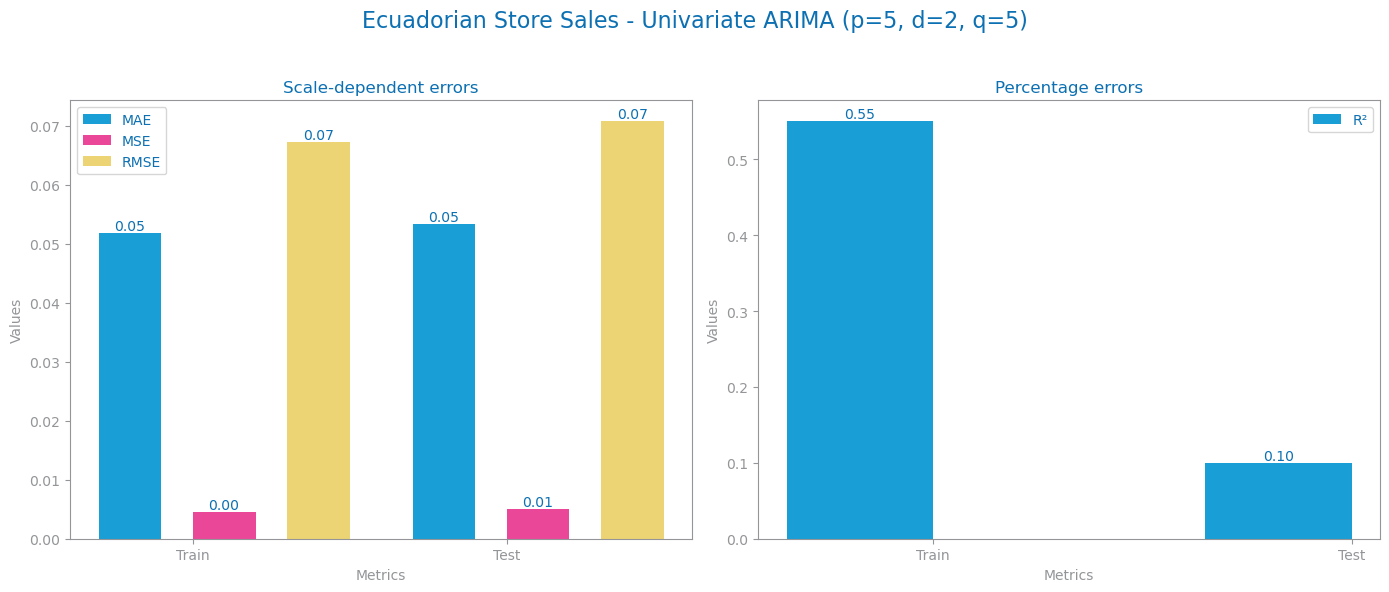

<Figure size 640x480 with 0 Axes>

In [135]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_single_model_evaluation(
    trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Univariate ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"{file_tag}_arima_{measure}_univariate_eval.png")

## ARIMA Plot

<Axes: xlabel='Date', ylabel='sales'>

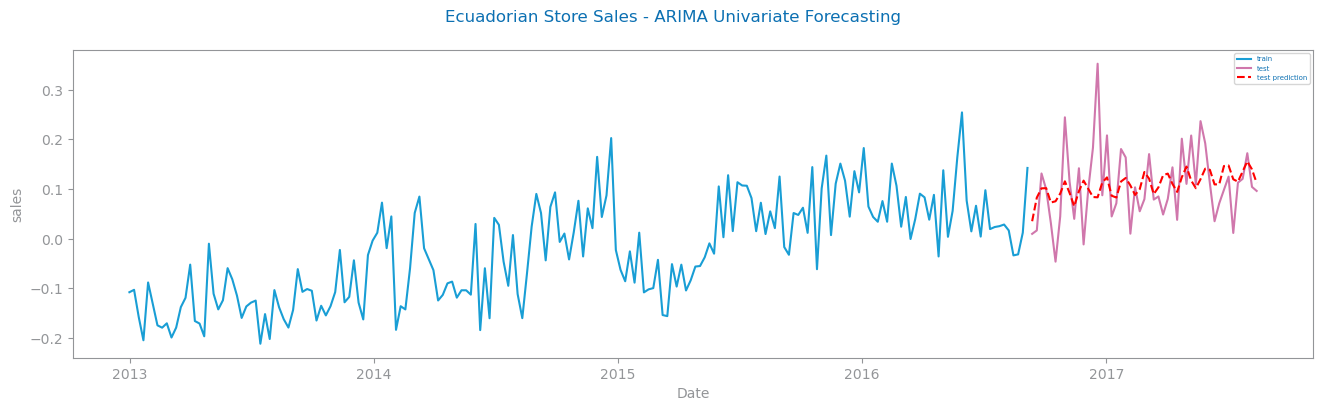

In [136]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - ARIMA Univariate Forecasting",
    xlabel='Date',
    ylabel=target,
)

# ARIMA Multivariate

In [137]:
train=pd.read_csv(f"dataset/series_scaled_agg_w_train_multi.csv", index_col='date', parse_dates=True,  infer_datetime_format=True)
test=pd.read_csv(f"dataset/series_scaled_agg_w_test_multi.csv", index_col='date', parse_dates=True,  infer_datetime_format=True)

target='sales'
file_tag = "Ecuadorian Store Sales"

trnX = train.drop(columns=[target])
trnY = train[target]
tstX = test.drop(columns=[target])
tstY = test[target]

## ARIMA Multivariate Study

NaN Check Before Processing - Train: 0 | Test: 0
NaN Check After Processing - Train: 0 | Test: 0
ARIMA best results with (p,d,q)=(3, 1, 7) ==> R2=0.36


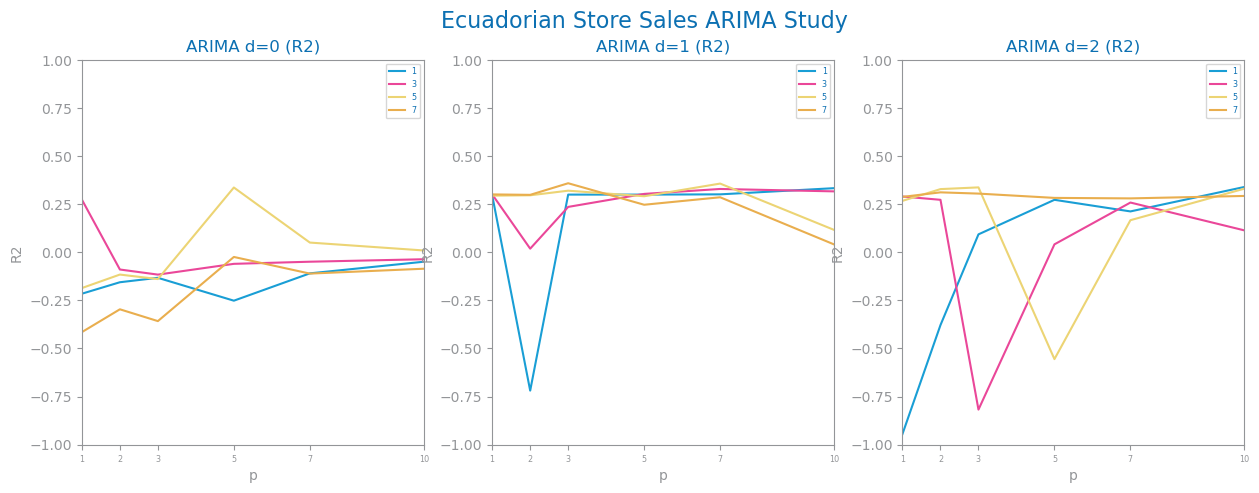

In [138]:
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart
from pandas import DataFrame
from numpy import isfinite
from statsmodels.tsa.arima.model import ARIMA
import warnings

def arima_multi_study(train: DataFrame, test: DataFrame, target: str, measure: str = "R2", freq: str = None):
    # Ensure the index is datetime-based
    if not isinstance(train.index, pd.DatetimeIndex):
        raise ValueError("Train data index must be a DateTime index.")
    if not isinstance(test.index, pd.DatetimeIndex):
        raise ValueError("Test data index must be a DateTime index.")

    # Print initial NaN check
    print(f"NaN Check Before Processing - Train: {train.isna().sum().sum()} | Test: {test.isna().sum().sum()}") 

    # Handle NaN or infinite values (apply forward fill where applicable)
    train = train[isfinite(train).all(axis=1)].fillna(method="ffill").dropna()
    test = test[isfinite(test).all(axis=1)].fillna(method="ffill").dropna()

    print(f"NaN Check After Processing - Train: {train.isna().sum().sum()} | Test: {test.isna().sum().sum()}") 

    # Set frequency if provided
    if freq:
        train = train.asfreq(freq, method='ffill')
        test = test.asfreq(freq, method='ffill')

    trnY = train[target]
    tstY = test[target]
    trnX = train.drop(columns=[target])
    tstX = test.drop(columns=[target])

    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    flag = measure in ["R2", "MAPE"]
    best_model = None
    best_params = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * 5, 5))
    fig.suptitle(f"{file_tag} ARIMA Study", fontsize=16)  

    for i, d in enumerate(d_values):
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                try:
                    # Double-check that no NaN values exist before training
                    if trnY.isna().any() or trnX.isna().any().any():
                        raise ValueError("Training data contains NaN values.")
                    if tstY.isna().any() or tstX.isna().any().any():
                        raise ValueError("Test data contains NaN values.")

                    arima = ARIMA(endog=trnY, exog=trnX, order=(p, d, q))
                    model = arima.fit(method_kwargs={"maxiter": 50})  
                    prd_tst = model.forecast(steps=len(tstY), exog=tstX)

                    eval_score = FORECAST_MEASURES[measure](tstY, prd_tst)

                    if eval_score > best_performance and abs(eval_score - best_performance) > DELTA_IMPROVE:
                        best_performance = eval_score
                        best_params["params"] = (p, d, q)
                        best_model = model

                    yvalues.append(eval_score)
                except Exception as e:
                    print(f"ARIMA ({p}, {d}, {q}) failed: {e}")
                    yvalues.append(None)
            values[q] = yvalues
        
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )

    if best_params["params"]:
        print(
            f"ARIMA best results with (p,d,q)=({best_params['params'][0]}, {best_params['params'][1]}, {best_params['params'][2]})"
            f" ==> {measure}={best_performance:.2f}"
        )
    else:
        print("No valid ARIMA model found.")

    return best_model, best_params

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

measure = 'R2'
best_model, best_params = arima_multi_study(train, test, target=target, measure=measure) #, freq='W')
savefig(f"{file_tag}_arima_multivariate_{measure}_study.png")


## ARIMA Multivariate Model

In [139]:
from statsmodels.tsa.arima.model import ARIMA

best_params["params"]

predictor = ARIMA(endog=trnY, exog=trnX, order=(best_params["params"][0], best_params["params"][1], best_params["params"][2]))
model = predictor.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  193
Model:                 ARIMA(3, 1, 7)   Log Likelihood                 259.540
Date:                Sun, 23 Mar 2025   AIC                           -495.080
Time:                        22:14:47   BIC                           -455.990
Sample:                    12-31-2012   HQIC                          -479.248
                         - 09-05-2016                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
onpromotion     0.0335      0.010      3.342      0.001       0.014       0.053
ar.L1          -0.0991      0.413     -0.240      0.810      -0.909       0.711
ar.L2          -0.0894      0.341     -0.262    

## ARIMA Multivariate Plot Diagnostics

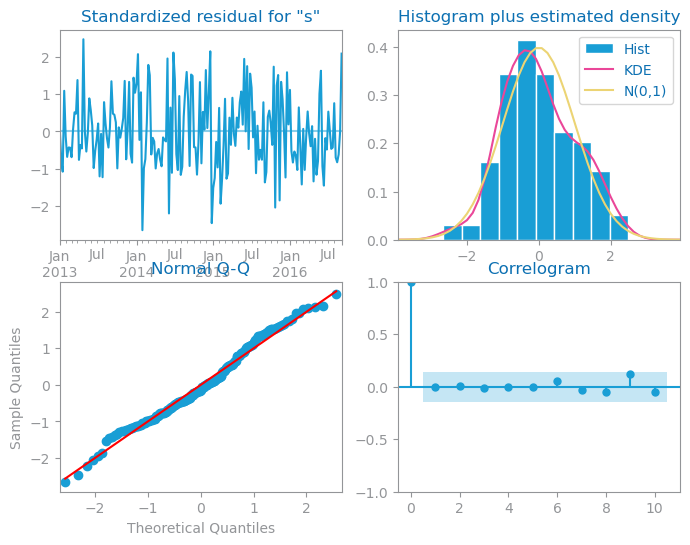

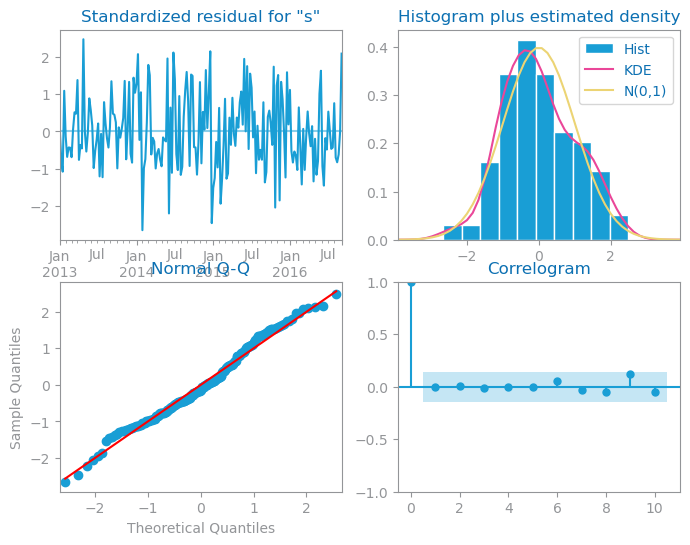

In [140]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))


## ARIMA Multivariate Evaluate

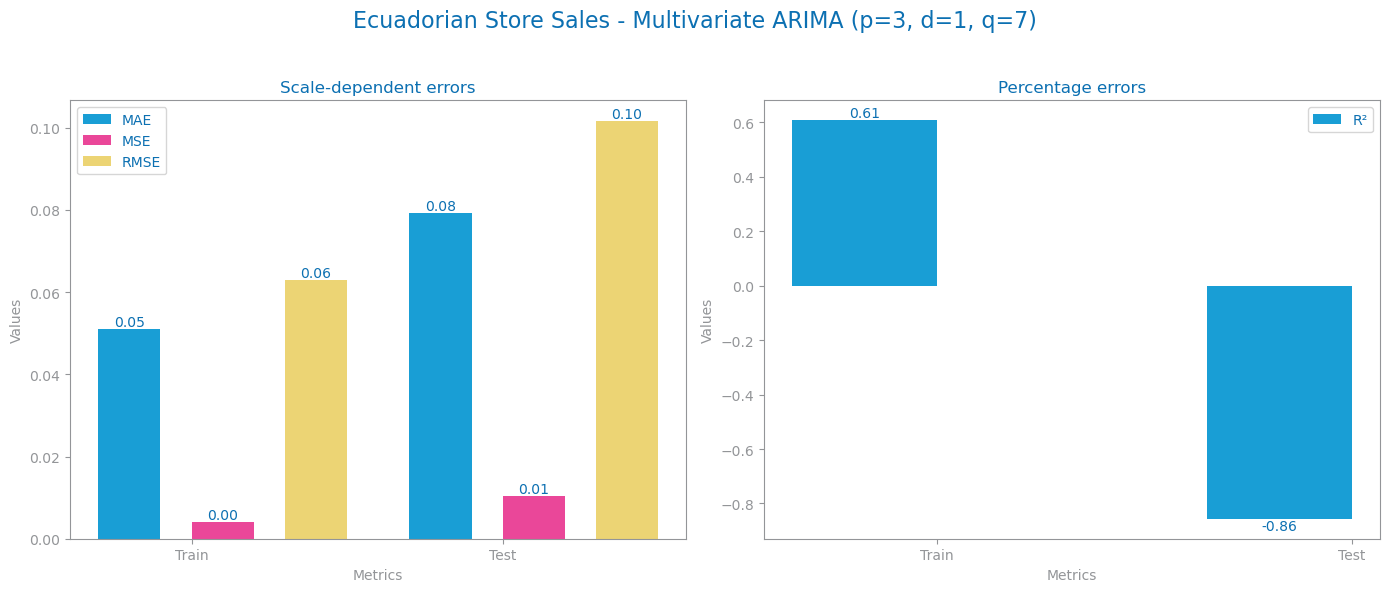

<Figure size 640x480 with 0 Axes>

In [141]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]

# For in-sample predictions (prd_trn), pass the exogenous variables step by step
prd_trn = []
for i in range(len(train)):
    prd_trn.append(best_model.predict(start=i, end=i, exog=trnX.iloc[i:i+1]))  # Pass one row at a time

prd_trn = np.array(prd_trn).flatten()  # Flatten the list of predictions into a 1D array

# Use the last available exogenous variables from the training set for forecasting
last_exog = trnX.iloc[-1].values.reshape(1, -1)  # Shape (1, num_exog)
# Repeat the last row for each test step to match the length of the forecast
exog_forecast = np.repeat(last_exog, len(test), axis=0)  # Shape (len(test), num_exog)

# For out-of-sample prediction, use the correctly shaped exog_forecast
prd_tst = best_model.forecast(steps=len(test), exog=exog_forecast)

# Plot the evaluation
plot_single_model_evaluation(
    trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Multivariate ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)

# Save the figure
savefig(f"{file_tag}_arima_{measure}_multivariate_eval.png")


In [142]:
# from dslabs_functions import plot_forecasting_eval

# params = best_params["params"]
# prd_trn = best_model.predict(start=0, end=len(train) - 1)

# # Use the last available exogenous variables from the training set for forecasting
# last_exog = trnX.iloc[-1].values.reshape(1, -1)
# exog_forecast = np.repeat(last_exog, len(test), axis=0)


# prd_tst = best_model.forecast(steps=len(test), exog=exog_forecast)

# plot_single_model_evaluation(
#     trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Multivariate ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
# )
# savefig(f"{file_tag}_arima_{measure}_multivariate_eval.png")

## ARIMA Multivariate Plot

<Axes: xlabel='Date', ylabel='sales'>

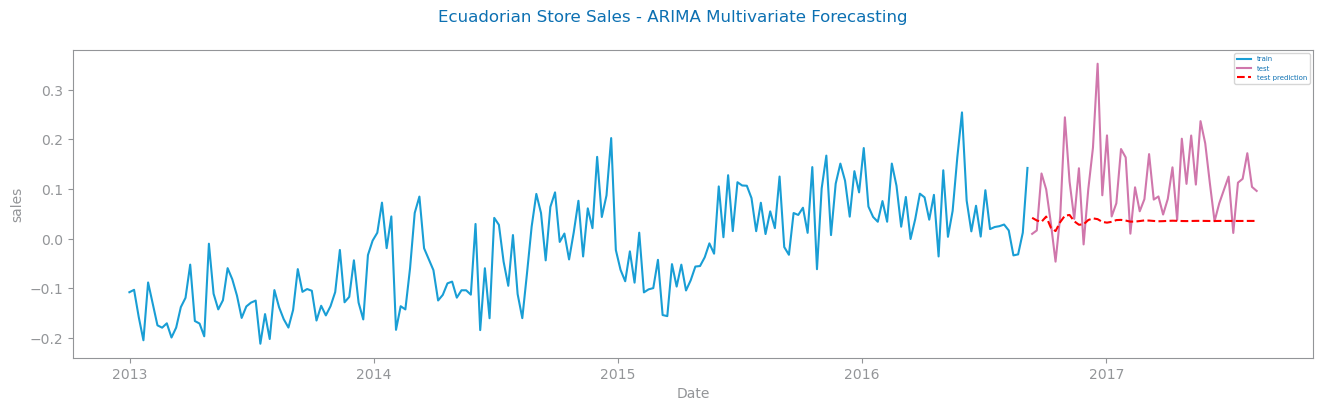

In [143]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - ARIMA Multivariate Forecasting",
    xlabel='Date',
    ylabel=target,
)